In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [38]:
base_path = "C:/Users/mjpearl/Desktop/projects/virtual_environments/kaggle/elo_merchant/data/"
historical_transactions = pd.read_csv(base_path+"historical_transactions.csv")
merchants = pd.read_csv(base_path+"merchants.csv")
new_merchant_transactions = pd.read_csv(base_path+"new_merchant_transactions.csv")
sample_submission = pd.read_csv(base_path+"sample_submission.csv")
train = pd.read_csv(base_path+"train.csv")
test = pd.read_csv(base_path+"test.csv")

### Project: Udacity Capstone Elo Merchant Category Recommendation
#### Data Exploration
Initial data exploration will look at samples of all existing datasets for the competition and determine missing data, outliers, feature distributions. This will inform the cleansing activity we need to conduct to account for missing and outlier values across all datasets, as well as uncover relationships and feature importance. 

In [5]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [7]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [8]:
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [9]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [10]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


##### Training Dataset
Lets plot the distribution for the loyal score to determine if any outliers exist in the data.

In [11]:
train.describe(include='all')

,first_active_month,card_id,feature_1,feature_2,feature_3,target
count,201917,201917,201917.000000,201917.000000,201917.000000,201917.000000
unique,75,201917,NaN,NaN,NaN,NaN
top,2017-09,C_ID_f036c02659,NaN,NaN,NaN,NaN
freq,13878,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.105311,1.745410,0.565569,-0.393636
std,NaN,NaN,1.186160,0.751362,0.495683,3.850500
min,NaN,NaN,1.000000,1.000000,0.000000,-33.219281
25%,NaN,NaN,2.000000,1.000000,0.000000,-0.883110
50%,NaN,NaN,3.000000,2.000000,1.000000,-0.023437
75%,NaN,NaN,4.000000,2.000000,1.000000,0.765453


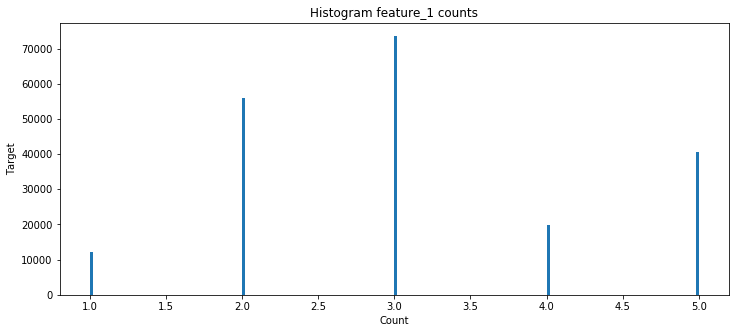

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_1.values, bins=200)
plt.title('Histogram feature_1 counts')
plt.xlabel('Count')
plt.ylabel('Target')  
plt.show()

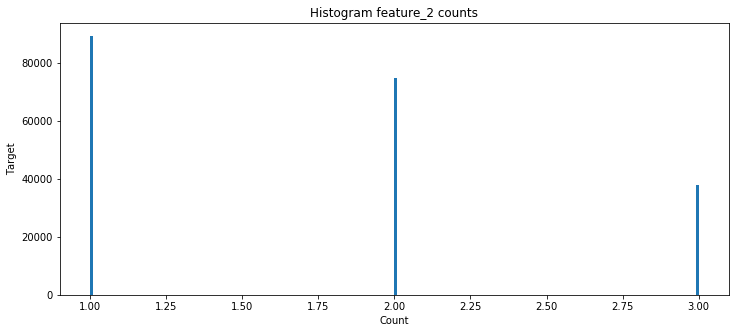

In [13]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_2.values, bins=200)
plt.title('Histogram feature_2 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

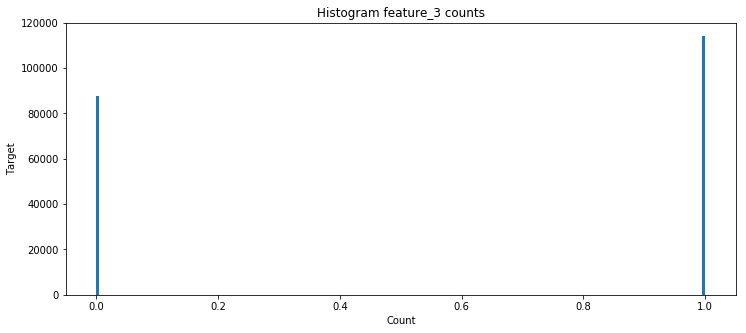

In [14]:
plt.figure(figsize=(12, 5))
plt.hist(train.feature_3.values, bins=200)
plt.title('Histogram feature_3 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

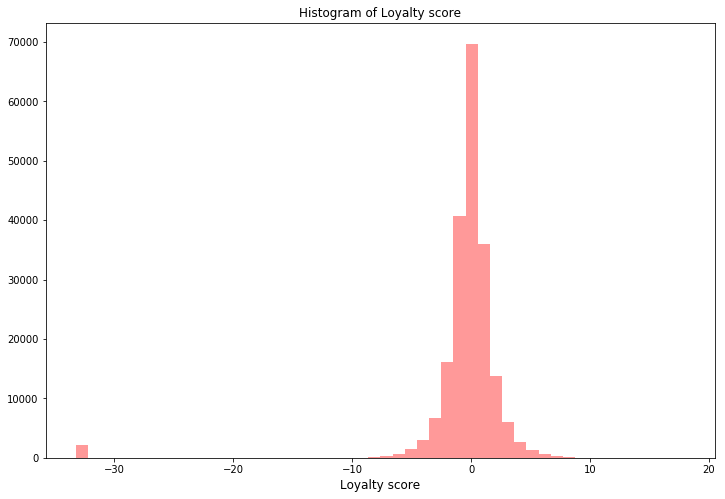

In [15]:
plt.figure(figsize=(12,8))
sns.distplot(train['target'].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

Based on the results below we can see that the loyalty score in the training dataset typically falls a normal distribution. However, some outlier values exist that are < -30 which could potentially have an impact on the accuracy of the results. This could increase the considerations for removing these in the model training process.

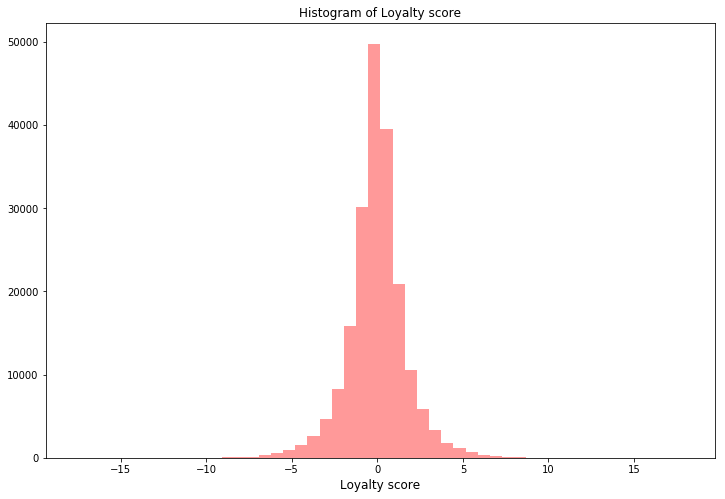

In [16]:
train = train[train.target > -20]
plt.figure(figsize=(12,8))
sns.distplot(train['target'].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

#### Feature engineering
Now we're going to use the compute the aggregate measures across the various input datasets (i.e. mean, median, min, max) to assess which can be included as relevant features. In addition, we will use get_dummies to encode all categorical features present within the training, test and purchase oriented datasets (i.e historical and merchant transactions). We're also going to account for missing values within certain features and binarize and features with "Yes" or "No" values. 

In [39]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
train['elapsed_time'] = (datetime.date(2018, 2, 18) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 18) - test['first_active_month'].dt.date).dt.days
train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])
test = pd.get_dummies(test, columns=['feature_1', 'feature_2'])

In [40]:
train.head()

,first_active_month,card_id,feature_3,target,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-06-01,C_ID_92a2005557,1,-0.820283,262,0,0,0,0,1,0,1,0
1,2017-01-01,C_ID_3d0044924f,0,0.392913,413,0,0,0,1,0,1,0,0
2,2016-08-01,C_ID_d639edf6cd,0,0.688056,566,0,1,0,0,0,0,1,0
3,2017-09-01,C_ID_186d6a6901,0,0.142495,170,0,0,0,1,0,0,0,1
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159749,109,1,0,0,0,0,0,0,1


In [41]:
test.head()

,first_active_month,card_id,feature_3,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-04-01,C_ID_0ab67a22ab,1,323.0,0,0,1,0,0,0,0,1
1,2017-01-01,C_ID_130fd0cbdd,0,413.0,0,1,0,0,0,0,0,1
2,2017-08-01,C_ID_b709037bc5,1,201.0,0,0,0,0,1,1,0,0
3,2017-12-01,C_ID_d27d835a9f,0,79.0,0,1,0,0,0,1,0,0
4,2015-12-01,C_ID_2b5e3df5c2,1,810.0,0,0,0,0,1,1,0,0


In [42]:
"""
Method used to reduce memory usage for numeric and float datatypes for a given pandas dataframe. 
Credit to https://www.kaggle.com/fabiendaniel/elo-world for the method.
"""
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [43]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_merchant_transactions = binarize(new_merchant_transactions)

historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_merchant_transactions = pd.get_dummies(new_merchant_transactions, columns=['category_2', 'category_3'])

historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [44]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,0,0,0,0,1,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,0,0,0,0,0,1,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,0,0,0,0,0,1,0


In [45]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_merchant_transactions = reduce_mem_usage(new_merchant_transactions)
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)
Mem. usage decreased to  5.58 Mb (39.6% reduction)
Mem. usage decreased to  3.18 Mb (32.5% reduction)



Now we're going to use the compute the aggregate measures across the various input datasets (i.e. mean, median, min, max) to assess which can be included as relevant features. In addition, we will use get_dummies to encode all categorical features present within the training, test and purchase oriented datasets (i.e historical and merchant transactions). We're also going to account for missing values within certain features and binarize and features with "Yes" or "No" values. 

In [46]:
def aggregate_transactions(trans, prefix):  
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [47]:
historical_transactions_agg = aggregate_transactions(historical_transactions,prefix='hist_')
new_merchant_transactions_agg = aggregate_transactions(new_merchant_transactions,prefix='new_')

train = train.merge(historical_transactions_agg,on="card_id",how="left")
test = test.merge(historical_transactions_agg,on="card_id",how="left")

train = train.merge(new_merchant_transactions_agg,on="card_id",how="left")
test = test.merge(new_merchant_transactions_agg,on="card_id",how="left")

c:\users\mjpearl\desktop\projects\virtual_environments\kaggle\elo_merchant\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [48]:
train.head()

,first_active_month,card_id,feature_3,target,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,...,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,2017-06-01,C_ID_92a2005557,1,-0.820312,262,0,0,0,0,1,...,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,4742309.0,1.0,2.0
1,2017-01-01,C_ID_3d0044924f,0,0.392822,413,0,0,0,1,0,...,-0.739258,0.014381,6.0,1.000000,1.0,1.0,0.000000,4887632.0,1.0,2.0
2,2016-08-01,C_ID_d639edf6cd,0,0.687988,566,0,1,0,0,0,...,-0.700195,NaN,0.0,0.000000,0.0,0.0,NaN,0.0,2.0,2.0
3,2017-09-01,C_ID_186d6a6901,0,0.142456,170,0,0,0,1,0,...,-0.734375,0.065918,5.0,0.714286,1.0,-1.0,0.755929,3625505.0,1.0,2.0
4,2017-11-01,C_ID_cdbd2c0db2,0,-0.159790,109,1,0,0,0,0,...,-0.739258,0.223877,35.0,0.972222,2.0,-1.0,0.376913,4949682.0,1.0,2.0


In [49]:
test.head()

,first_active_month,card_id,feature_3,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,...,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,2017-04-01,C_ID_0ab67a22ab,1,323.0,0,0,1,0,0,0,...,-0.722168,0.182861,5.0,1.666667,3.0,1.0,1.154701,2193863.0,2.0,2.0
1,2017-01-01,C_ID_130fd0cbdd,0,413.0,0,1,0,0,0,0,...,-0.740723,0.071167,11.0,1.222222,3.0,1.0,0.666667,4167689.0,1.0,2.0
2,2017-08-01,C_ID_b709037bc5,1,201.0,0,0,0,0,1,1,...,-0.724609,1.152344,11.0,5.500000,10.0,1.0,6.363961,1030753.0,1.0,1.0
3,2017-12-01,C_ID_d27d835a9f,0,79.0,0,1,0,0,0,1,...,-0.671875,0.073181,29.0,2.900000,12.0,1.0,3.348300,3838554.0,1.0,2.0
4,2015-12-01,C_ID_2b5e3df5c2,1,810.0,0,0,0,0,1,1,...,-0.704102,6.027344,5.0,0.833333,2.0,-1.0,0.983192,3402694.0,1.0,2.0


In [56]:
y_train = train["target"].values
X_train = train.drop(columns=["target","card_id","first_active_month"],axis=1).values
X_test =test.drop(columns=["card_id","first_active_month"],axis=1).values

from sklearn.model_selection import train_test_split as tts
Trn_x,val_x,Trn_y,val_y = tts(X_train,y_train,test_size =0.1,random_state = 7)
trn_x , test_x, trn_y, test_y = tts(Trn_x , Trn_y, test_size =0.1, random_state = 7)

[[1.000000e+00 9.010000e+02 0.000000e+00 ... 3.229915e+06 1.000000e+00
  2.000000e+00]
 [1.000000e+00 2.320000e+02 0.000000e+00 ... 4.443108e+06 1.000000e+00
  2.000000e+00]
 [0.000000e+00 2.320000e+02 0.000000e+00 ... 4.841988e+06 1.000000e+00
  2.000000e+00]
 ...
 [0.000000e+00 7.190000e+02 0.000000e+00 ... 2.844925e+06 1.000000e+00
  2.000000e+00]
 [1.000000e+00 4.440000e+02 0.000000e+00 ...          nan          nan
           nan]
 [1.000000e+00 6.580000e+02 0.000000e+00 ... 0.000000e+00 2.000000e+00
  2.000000e+00]]


In [60]:
trn_x = np.nan_to_num(trn_x)
test_x = np.nan_to_num(test_x)
trn_y = np.nan_to_num(trn_y)
test_y = np.nan_to_num(test_y)

In [65]:
from sklearn.metrics import mean_squared_error as mse, r2_score
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(trn_x, trn_y)

# Make predictions using the testing set
baseline_y_pred = regr.predict(test_x)

# The root mean squared error
print("Root Mean squared error: %.2f"
      % np.sqrt(mse(test_y, baseline_y_pred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_y, baseline_y_pred))

Root Mean squared error: 3.79
Variance score: 0.03


In [23]:
# converting into xgb DMatrix
Train = xgb.DMatrix(trn_x,label = trn_y)
Validation = xgb.DMatrix(val_x, label = val_y)
Test = xgb.DMatrix(test_x)

In [25]:
xgb1 = XGBRegressor()
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 10,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  27 | elapsed: 81.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'nthread': [-1], 'objective': ['reg:linear'], 'learning_rate': [0.03, 0.05, 0.07], 'max_depth': [5, 6, 7], 'min_child_weight': [4], 'silent': [1], 'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [26]:
history ={}  # This will record rmse score of training and test set
eval_list =[(Train,"Training"),(Validation,"Validation")]
params = xgb_grid.best_params

In [27]:
clf = xgb.train(params, Train, num_boost_round=119, evals=eval_list, obj=None, feval=None, maximize=False, 
          early_stopping_rounds=40, evals_result=history)

[0]	Training-rmse:1.78774	Validation-rmse:1.80039
Multiple eval metrics have been passed: 'Validation-rmse' will be used for early stopping.

Will train until Validation-rmse hasn't improved in 40 rounds.
[1]	Training-rmse:1.77741	Validation-rmse:1.78998
[2]	Training-rmse:1.76775	Validation-rmse:1.78039
[3]	Training-rmse:1.75852	Validation-rmse:1.77125
[4]	Training-rmse:1.74976	Validation-rmse:1.76267
[5]	Training-rmse:1.74138	Validation-rmse:1.75431
[6]	Training-rmse:1.73354	Validation-rmse:1.74653
[7]	Training-rmse:1.72611	Validation-rmse:1.73917
[8]	Training-rmse:1.71885	Validation-rmse:1.73214
[9]	Training-rmse:1.71214	Validation-rmse:1.72558
[10]	Training-rmse:1.70561	Validation-rmse:1.71904
[11]	Training-rmse:1.69945	Validation-rmse:1.71297
[12]	Training-rmse:1.69366	Validation-rmse:1.70732
[13]	Training-rmse:1.68799	Validation-rmse:1.70179
[14]	Training-rmse:1.68277	Validation-rmse:1.6967
[15]	Training-rmse:1.67776	Validation-rmse:1.69188
[16]	Training-rmse:1.67294	Validation-rm

Text(0.5, 1.0, 'learning curve')

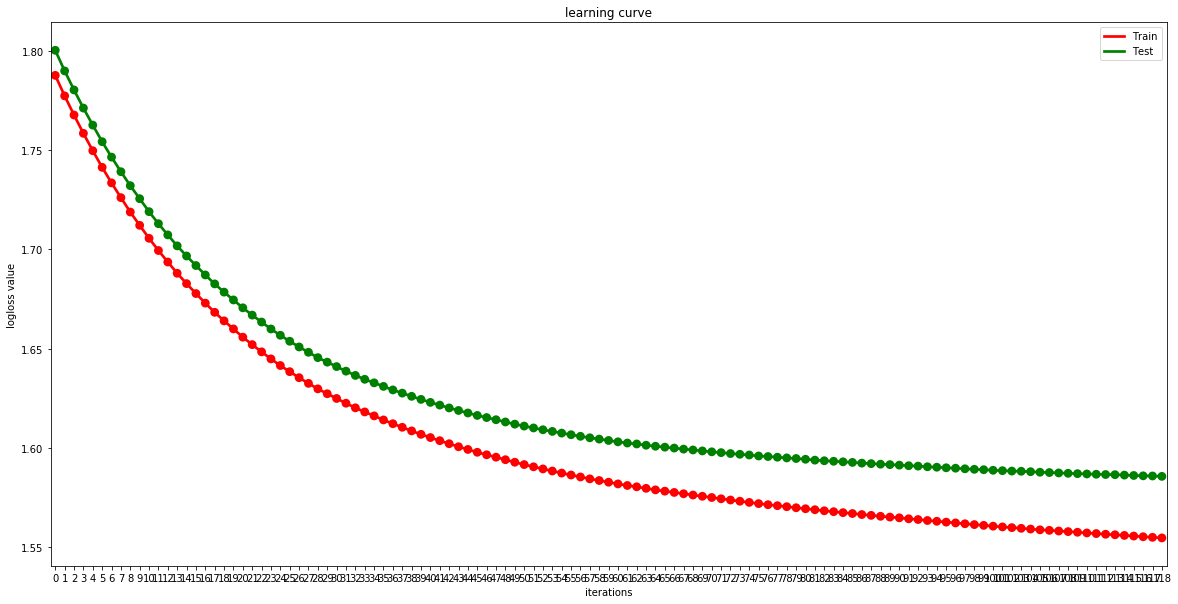

In [28]:
# dataframe of progress
f,ax=plt.subplots(1,1)
f.set_figheight(10)
f.set_figwidth(20)
df_performance=pd.DataFrame({"train":history["Training"]["rmse"],"test":history["Validation"]["rmse"]}).reset_index(drop=False)
sns.pointplot(ax=ax,y="train",x="index",data=df_performance,color="r")
sns.pointplot(ax=ax,y="test",x="index",data=df_performance,color="g")
ax.legend(handles=ax.lines[::len(df_performance)+1], labels=["Train","Test"])
plt.xlabel('iterations'); plt.ylabel('logloss value'); plt.title('learning curve')

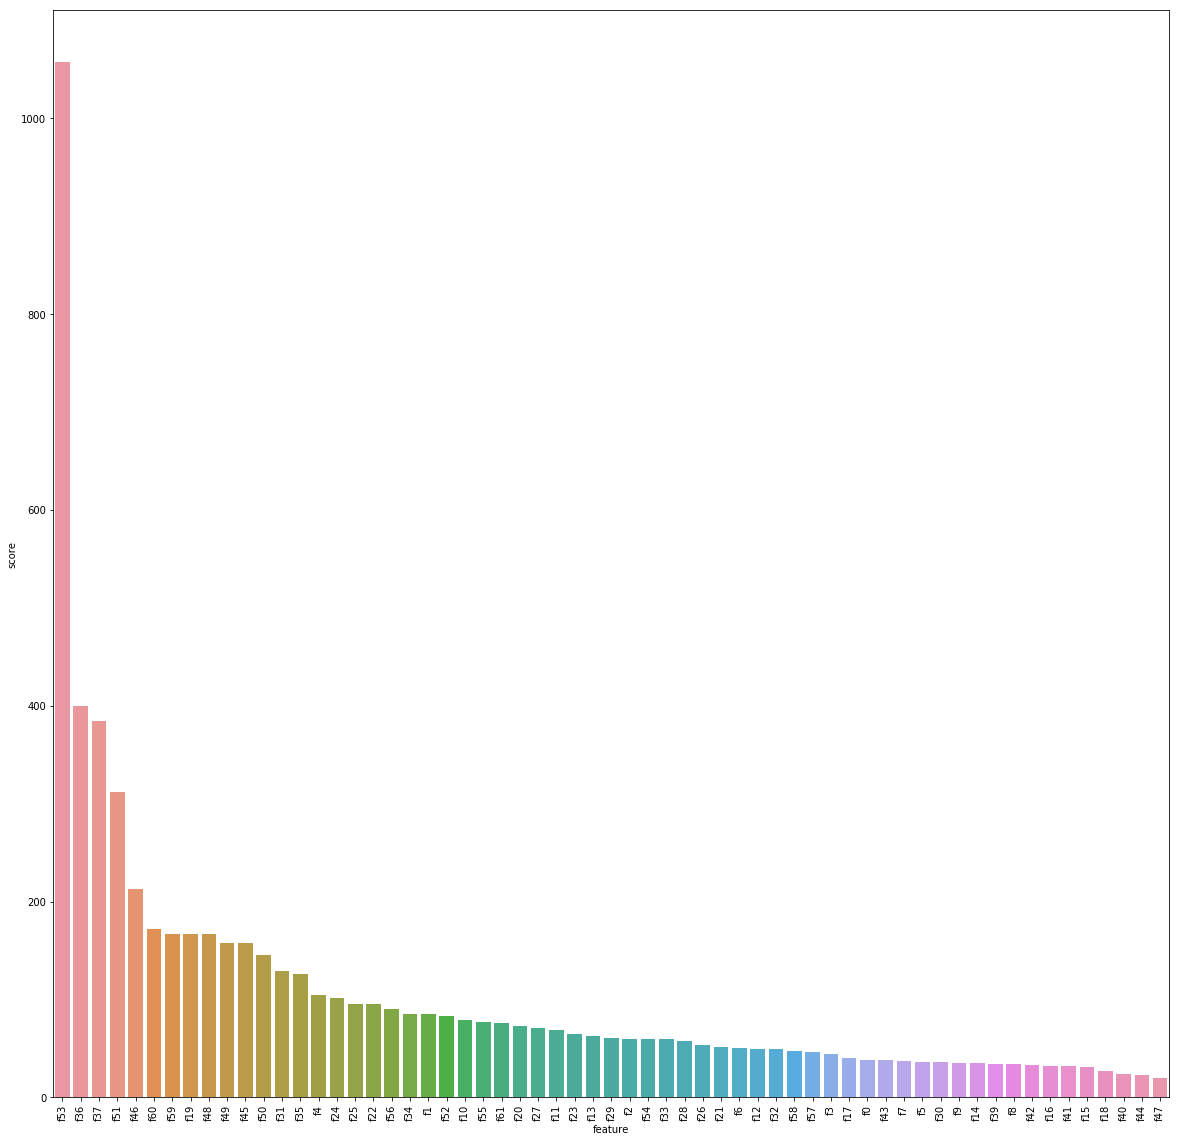

In [29]:
score=clf.get_score(importance_type="gain")
df=pd.DataFrame({"feature":list(score.keys()),"score":list(score.values())})
df=df.sort_values(by="score",ascending=False)
plt.figure(figsize=(20,20))
plt.xticks(rotation="vertical")
sns.barplot(x="feature",y="score",data=df,orient="v")

In [30]:
# Checking rmse on test set (kept during data splitting)
from sklearn.metrics import mean_squared_error as mse
pred_test = clf.predict(Test)
score = mse(test_y , pred_test)
print(np.sqrt(score))

1.5589178


In [31]:
prediction = clf.predict(xgb.DMatrix(X_test))
df_submission=pd.DataFrame()
df_submission["card_id"] = test["card_id"].values
df_submission["target"] = np.ravel(prediction)
df_submission[["card_id","target"]].to_csv("new_submission.csv",index=False)